## Problem Overview
Efforts to understand the influence of historical climate change, at global and regional levels, have been increasing over the past decade. In particular, the estimates of air temperatures have been considered as a key factor in climate impact studies on agricultural, ecological, environmental, and industrial sectors.

![](https://dphi-courses.s3.ap-south-1.amazonaws.com/Datathons/temperature_change.png)

Mitigating climate change is one of the biggest challenges of humankind. Despite the complexity of predicting the effects of climate change on earth, there is a scientific consensus about its negative impacts. Among them, the affectation of ecosystems, decrease of biodiversity, soil erosion, extreme changes in temperature, sea level rise, and global warming have been identified. Likewise, impacts on the economy, human health, food security and energy consumption are expected.

Specifically, air temperature forecasting has been a crucial climatic factor required for many different applications in areas such as agriculture, industry, energy, environment, tourism, etc. Some of these applications include short-term load forecasting for power utilities, air conditioning and solar energy systems development, adaptive temperature control in greenhouses, prediction and assessment of natural hazards, and prediction of cooling and energy consumption in residential buildings. Therefore, there is a need to accurately predict temperature values because, in combination with the analysis of additional features in the subject of interest, they would help to establish a planning horizon for infrastructure upgrades, insurance, energy policy, and business development. [source of information: mdpi]

## Objective
Build a Machine Learning model to predict the future temperature of the city.

## Evaluation Criteria
Submissions are evaluated using the Root Mean Squared Error (RMSE).

![](https://dphi-courses.s3.ap-south-1.amazonaws.com/Datathons/rmse+formula.png)



## About the Dataset
The train dataset contains the per day temperature values of the city - ‘XYZ’ for 30 years (1980 - 2010). The test set contains per day dates for the years 2011 - 2020 for which you will be predicting the temperature using the model you have built using the train dataset.

You can download the datasets from the given links:

- train - You can download the train dataset from [here](https://dphi-courses.s3.ap-south-1.amazonaws.com/data-science-challenges/DTU_RoundTable/new_train.csv). Use this data to build machine learning models.
- test - You can download the test dataset from [here](https://dphi-courses.s3.ap-south-1.amazonaws.com/data-science-challenges/DTU_RoundTable/new_test.csv). Predict the target values for this data using the model you built with the train data.
- sample_submission: This is a csv file that contains the sample submission for the challenge. You can download the file from [here](https://dphi-courses.s3.ap-south-1.amazonaws.com/data-science-challenges/DTU_RoundTable/sample_submission.csv).

## Data Description
`date`: date on which the temperature was observed  
`temp`: observed temperature on the given date



## What to Expect from this Notebook?

This notebook includes detailed exlanations and implementations of state-of-the-art Time Series Firecasting Algorithms. There are many variations of the algorithms, I have only shown a few. 

I have linked some great resources to most of the stuff in this notebook so that you can have loads of materials and examples to learn from. Some of these resources were even used by me to learn these concepts.

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

Mounted at /content/drive


## Libraries

In [104]:
#Import Libraries

import pandas as pd
import numpy as np

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

#DateTime
import datetime as dt

#Models
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

#SKLearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

#Time to run Program
import time 

## Load Data

In [4]:
def load_data():
  '''
  Function to Load the Train, Test and Submission Data

  returns: train, test, submission dataframes
  '''  

  train = pd.read_csv('/content/drive/MyDrive/Data Science/dare2compete/DTU RoundHacks Data Science Hackathon/new_train.csv')
  test = pd.read_csv('/content/drive/MyDrive/Data Science/dare2compete/DTU RoundHacks Data Science Hackathon/new_test.csv')
  submission = pd.read_csv('/content/drive/MyDrive/Data Science/dare2compete/DTU RoundHacks Data Science Hackathon/sample_submission.csv')

  return train, test, submission

In [12]:
#Declare Traget and Feature
TARGET = 'temp'
feature = ['date']

In [56]:
train, test, submission = load_data()

In [6]:
train.head()

,date,temp
0,01-01-1980,4.16
1,02-01-1980,4.06
2,03-01-1980,7.12
3,04-01-1980,9.23
4,05-01-1980,3.20


In [7]:
test.head()

,date
0,01-01-2011
1,02-01-2011
2,03-01-2011
3,04-01-2011
4,05-01-2011


In [8]:
submission.head()

,prediction
0,5.57
1,5.57
2,5.57
3,5.57
4,5.57


## Functions

In [10]:
#RMSE
def rmse():
  y_pred = train.iloc[10000:11322, 2]
  y = train.iloc[10000:11322, 0]
  metric = np.sqrt(mean_squared_error(y, y_pred))
  print(f"RMSE of Data is: {metric}")

#Hackathon Metric
def predict(model, model_features):
  pred_train = model.predict(X_train[model_features])
  pred_val = model.predict(X_val[model_features])

  print(f"Train RMSE = {np.sqrt(mean_squared_error(y_train, pred_train))}")
  print(f"Test RMSE = {np.sqrt(mean_squared_error(y_val, pred_val))}")

def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = metric(y_val, preds_val)
    print(f'\nRMSE score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = metric(target, oofs)
  print(f'\n\nRMSE for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

def metric(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  submission['prediction'] = preds_test

  ## 2. Saving our predictions to a csv file

  submission.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

#Download Submission File
def download(model, model_features, file_name = 'prophet.csv'):

  pred_test = model.predict(model_features)

  #Setting the target column with our obtained predictions
  submission['prediction'] = pred_test

  #Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)
  
  #Downloadingthe csv file
  files.download(file_name)

def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [feature, TARGET]]
  df[TARGET] = df[TARGET].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [feature, TARGET]]
  
  return train, test, features

## EDA and Data Preprocessing

In [57]:
#Combine Train and Test Dataframe
df, features = join_df(train, test)

In [14]:
df.head()

,date,temp
0,01-01-1980,1.640937
1,02-01-1980,1.621366
2,03-01-1980,2.094330
3,04-01-1980,2.325325
4,05-01-1980,1.435085


### Data Details

In [15]:
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")

train.shape: (11323, 2)
test.shape: (3561, 1)


In [16]:
train.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


In [17]:
#Check Datatypes
train.dtypes

date     object
temp    float64
dtype: object

Datatype of `date` is incorrect. It should be datetime. We will correct it in a later stage.

### Null Values

In [51]:
print(f"Train Null Value Count: {train.isnull().sum()}")
print(f"Test Null Value Count: {test.isnull().sum()}")

Train Null Value Count: date    0
temp    0
dtype: int64
Test Null Value Count: date    0
dtype: int64


Thus, Training Data does not have any null values.

### Target Distribution

Let us check the distribution of the TARGET i.e., Temperature.

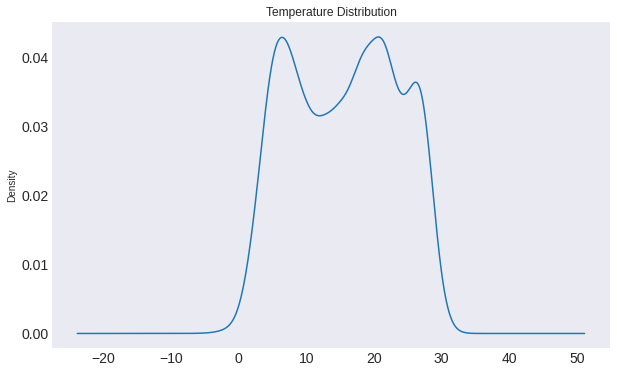

In [20]:
#Temperature Distribution
train[TARGET].plot(kind = 'density', title = 'Temperature Distribution', fontsize=14, figsize=(10, 6))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


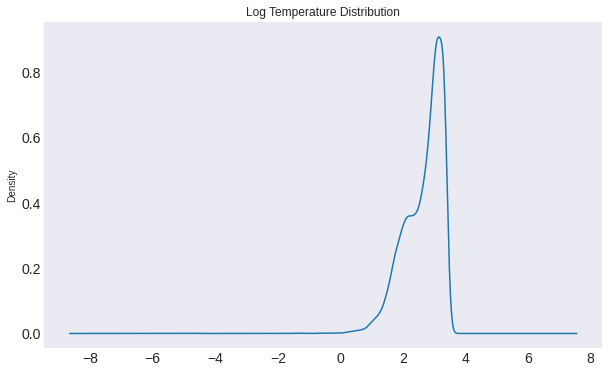

In [22]:
#Log Temperature Distribution
_ = pd.Series(np.log1p(train[TARGET])).plot(kind = 'density', title = 'Log Temperature Distribution', fontsize=14, figsize=(10, 6))

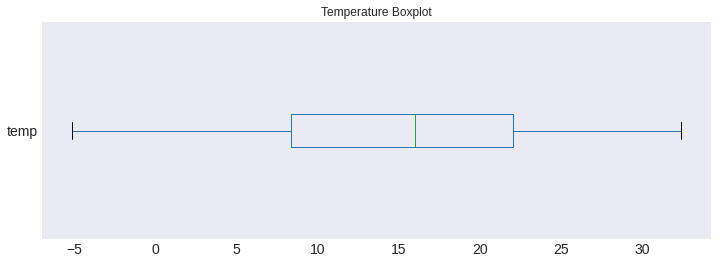

In [23]:
#Temperature Boxplot
train[TARGET].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Temperature Boxplot', fontsize=14)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


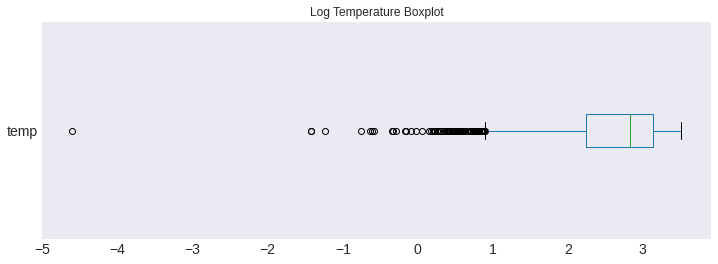

In [24]:
#Log Temperature BoxPlot
pd.Series(np.log1p(train[TARGET])).plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Log Temperature Boxplot', fontsize=14)

## Date Feature

Now we shall create some features using the `date` column.

In [58]:
#Convert `date` column datatype to `datetime`
df['date'] = pd.to_datetime(df['date'])

df.dtypes

date    datetime64[ns]
temp           float64
dtype: object

In [64]:
print(f"Train Null Value Count: {train.isnull().sum()}")
print(f"Test Null Value Count: {test.isnull().sum()}")

Train Null Value Count: date      0
temp     15
year      0
month     0
week      0
dtype: int64
Test Null Value Count: date        0
temp     3561
year        0
month       0
week        0
dtype: int64


In [63]:
#Make basic datetime features
# df['day_of_week'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week  

#Get Train and Test sets from df
train, test, features = split_df_and_get_features(df, train.shape[0])

#Define the features
features = [c for c in df.columns if c not in [feature, TARGET]]
features = features[1:]
features

['year', 'month', 'week']

There are many more functions in `datetime` library which you can try out for yourself. Check the [documentation](https://docs.python.org/3/library/datetime.html) for more such functions.

In [ ]:
df.head()

,date,temp,day_of_week,year,month,week
0,1980-01-01,4.16,1,1980,1,1
1,1980-02-01,4.06,4,1980,2,5
2,1980-03-01,7.12,5,1980,3,9
3,1980-04-01,9.23,1,1980,4,14
4,1980-05-01,3.20,3,1980,5,18


In [67]:
train.fillna(np.mean(train['temp']), inplace=True)

## Model

In [72]:
#Declare Features and Target from Training Dataset
X = train[features]
y = train[TARGET]

#Split Training and Validation Datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 42)

In [73]:
X.shape, y.shape

((11323, 3), (11323,))

We begin with a simple Linear Regression baseline model and then move ahead with more complex algorithms.

### Linear Regression

Linear regression is a linear model, e.g. a model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x).

When there is a single input variable (x), the method is referred to as simple linear regression. When there are multiple input variables, literature from statistics often refers to the method as multiple linear regression.

Different techniques can be used to prepare or train the linear regression equation from data, the most common of which is called Ordinary Least Squares. It is common to therefore refer to a model prepared this way as Ordinary Least Squares Linear Regression or just Least Squares Regression.

**RESOURCES:**
1. [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
2. [Linear Regression for Machine Learning](https://machinelearningmastery.com/linear-regression-for-machine-learning/#:~:text=Linear%20regression%20is%20a%20linear,the%20input%20variables%20(x).)
3. [Linear Regression](http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm)
4. [Linear Regression Detailed View](https://towardsdatascience.com/linear-regression-detailed-view-ea73175f6e86)
5. [Linear Regression Analysis using SPPS Statistics](https://statistics.laerd.com/spss-tutorials/linear-regression-using-spss-statistics.php)
6. [What is Linear Regression](https://www.statisticssolutions.com/what-is-linear-regression/?__cf_chl_jschl_tk__=3dc2b2683edb0777a0554f2afb84752a9d9e2ba2-1615132368-0-ASd1CvX_kwIZyocziRkwCHi7dmsfVurLvcRPIWFS5iKOECprgS1IJUetJqnAgimS2yijxcLIY7vRWIBshkoGno20f6Acx5Na3C_pkR0nP9WBd95Ma7v_arU9Owlh-LPuL5SofBxaHvN10g3d4xwKnMRtyNpaWGMOaQcCaZhPcls6UZhoI1gA0EXZoAe0yp5e2ULs0MirLFu_ezt07RgEAzTg1Od5LhTa585tKdIR0Y2ajxYfzpr9u35pdH26h05c8QS_e_3cEQh_iGPk1f8bmK3NHHYSUyvEv1wy1J8uLnB5XY3sHuMG2rCRuf-jBUQ7PDCPyLXlmi4by7bgw3n2UzaTY1u9sca3wI3uKlpb-8Tc)
7. [Introduction to Linear Regression Analysis](http://people.duke.edu/~rnau/regintro.htm)

In [74]:
#Linear Regression
model = LinearRegression()

model.fit(X_train[features], y_train)

predict(model, features)

Train RMSE = 0.5928992504796073
Test RMSE = 0.6142380849281177


### LGBMRegressor

LightGBM short for Light Gradient Boosted Machine, is a library developed at Microsoft that provides an efficient implementation of the gradient boosting algorithm.

The primary benefit of the LightGBM is the changes to the training algorithm that make the process dramatically faster, and in many cases, result in a more effective model.

For more technical details on the LightGBM algorithm, see the paper:

- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree, 2017](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree).

**RESOURCES:**
1. [Documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)
2. [How to use LightGBM](https://www.dezyre.com/recipes/use-lightgbm-classifier-and-regressor-in-python)
3. [What is LightGBM, How to implement it? How to fine tune the parameters?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)
4. [Python Examples of LightGBM](https://www.programcreek.com/python/example/88794/lightgbm.LGBMRegressor)
5. [Understanding LightGBM Parameters](https://neptune.ai/blog/lightgbm-parameters-guide)
6. [Gradient Boosting with Scikit-Learn, XGBoost, LightGBM, and CatBoost](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[54]	valid_0's rmse: 0.523947

RMSE score for validation set is 0.5239471286267389

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.527951
Early stopping, best iteration is:
[198]	valid_0's rmse: 0.506952

RMSE score for validation set is 0.5069516550458518

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.444474
Early stopping, best iteration is:
[242]	valid_0's rmse: 0.434738

RMSE score for validation set is 0.4347375096137859

------------- Fold 4 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.438418
Early stopping, best iteration is:
[357]	valid_0's rmse: 0.437303

RMSE score for validation set is 0.43730257584962584

------------- Fold 5 -------------

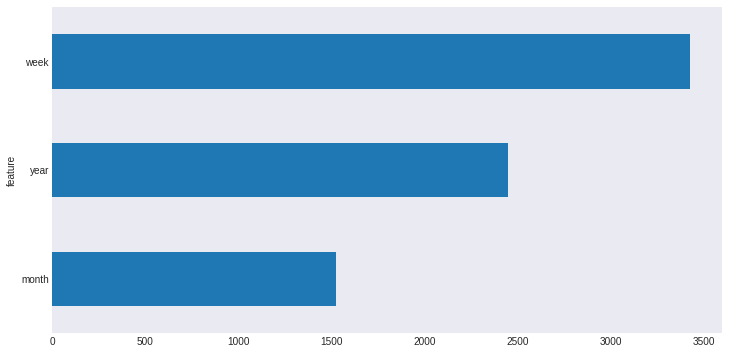

In [75]:
model = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf = model, fit_params = fit_params, train = train, test = test, features = features)

## Time Series Forecasting using ARIMA and SARIMAX

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

**RESOURCES:**

1. [Documentation](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html)
2. [Forecasting Future Sales using ARIMA and SARIMAX](https://www.youtube.com/watch?v=2XGSIlgUBDI)
3. [ARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=ARIMA%20is%20an%20acronym%20that,structures%20in%20time%20series%20data.) 
4. [Autoregressive Integrated Moving Average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
5. [ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
6. [Introduction to ARIMA](https://people.duke.edu/~rnau/411arim.htm)
7. [Autoregressive Integrated Moving Average (ARIMA)](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp)
8. [Time Series Forecasting - ARIMA Models](https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06)
9. [Understanding ARIMA Time Series Modelling](https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8)
10. [How to Create an ARIMA Model for Time Series Forecasting in Python](https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/)
11. [Time Series ARIMA Models](https://sites.google.com/site/econometricsacademy/econometrics-models/time-series-arima-models)


**Autoregressive Integrated Moving Averages**  

The general process is as follows:  
- Visualize the time series data
- Make the time series data stationary
- Plot the Correlation and Autocorrelation charts
- Use the model to make predictions

### Preprocess Data

In [77]:
#Load Data
train, test, submission = load_data()

In [78]:
#Convert `date` column to datetime
train.date = pd.to_datetime(train.date)

In [79]:
#Set `date` as index
train.set_index('date', inplace = True)

In [80]:
train.head()

,temp
date,
1980-01-01,4.16
1980-02-01,4.06
1980-03-01,7.12
1980-04-01,9.23
1980-05-01,3.20


In [81]:
train.describe()

,temp
count,11323.000000
mean,15.573259
std,7.877191
min,-5.110000
25%,8.390000
50%,15.990000
75%,22.055000
max,32.390000


### Visualize Data

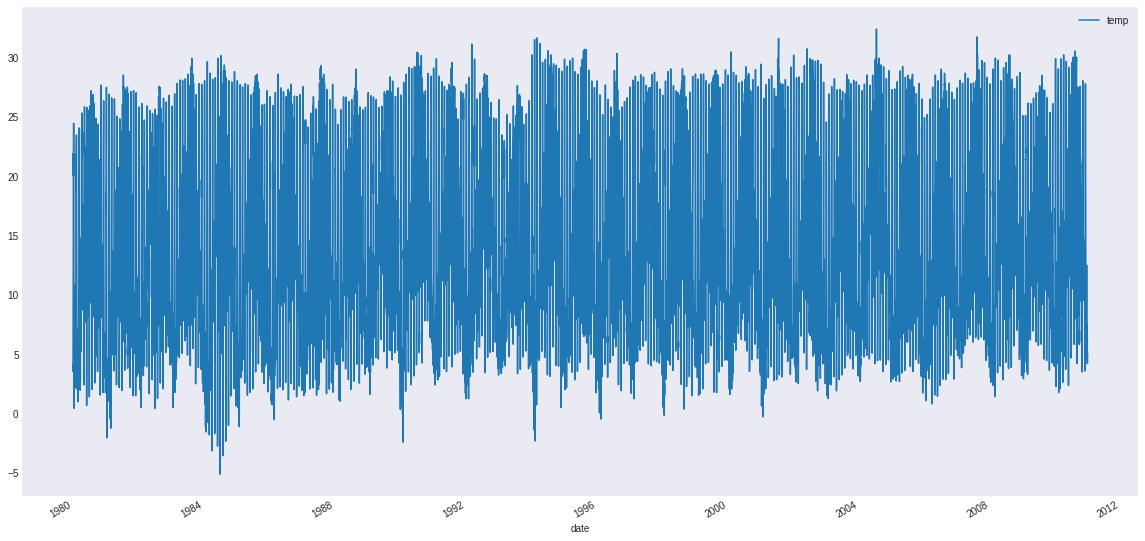

In [82]:
train.plot(figsize = (20, 10))

From the plot we observe that the data is seasonal.

### Make Data Stationary

To check if the data is stationary, we perform the `adfuller` test.

In [85]:
#Import adfuller test
from statsmodels.tsa.stattools import adfuller

In [84]:
# test_result = adfuller(train.temp)

In [86]:
#H0: It is not stationary
#H1: It is stationary

def adfuller_test(temp):
    result=adfuller(temp)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [88]:
adfuller_test(train.temp)

ADF Test Statistic : -10.245075802603546
p-value : 4.64050192615655e-18
#Lags Used : 40
Number of Observations Used : 11282
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Since data is already stationary, we do not need to perform differencing and can set `d=0` directly.

ADF Test Statistic : -8.151279157068213
p-value : 9.681017925784175e-13
#Lags Used : 40
Number of Observations Used : 11270
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


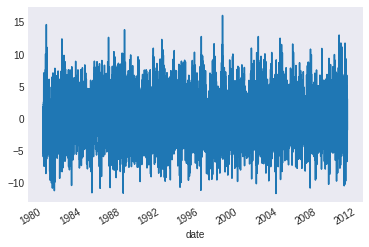

In [89]:
train['Seasonal First Difference']=train['temp']-train['temp'].shift(12) #Because 1 year has 12 months

## Again test dickey fuller test
adfuller_test(train['Seasonal First Difference'].dropna())

train['Seasonal First Difference'].plot()

## Auto Regressive Model

**Autocorrelation and Partial Autocorrelation**  

- Identification of an AR model is often best done with the PACF.
 - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
 - Look for sudden drop

- Identification of an MA model is often best done with the ACF rather than the PACF.
 - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
 - Look for exponential drop

**Parameters for ARIMA**
1. p - Autoregressive (AR) Model Lags - Use PACF
2. d - No. of times differencing performed
3. q - Moving Average (MA) Lags - Use ACF

In [90]:
from statsmodels.graphics.tsaplots import plot_pacf ,plot_acf

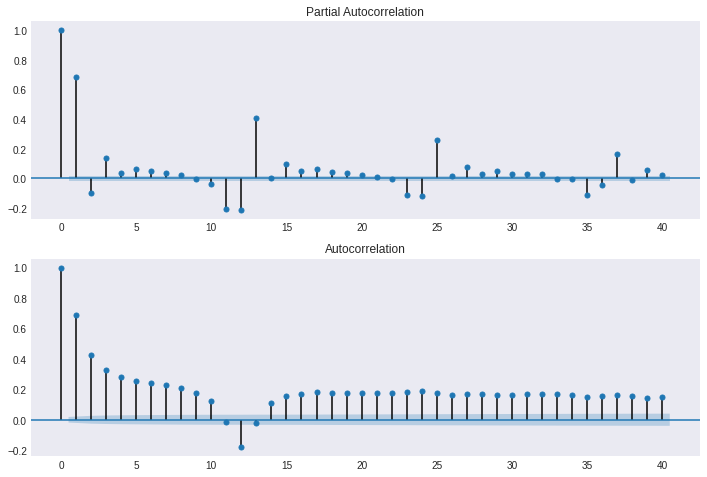

In [91]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(train['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(train['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

- From PACF sudden drop is observed at 2 so `p=2`.

- From ACF exponential drop is till 10 so `q=10`

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


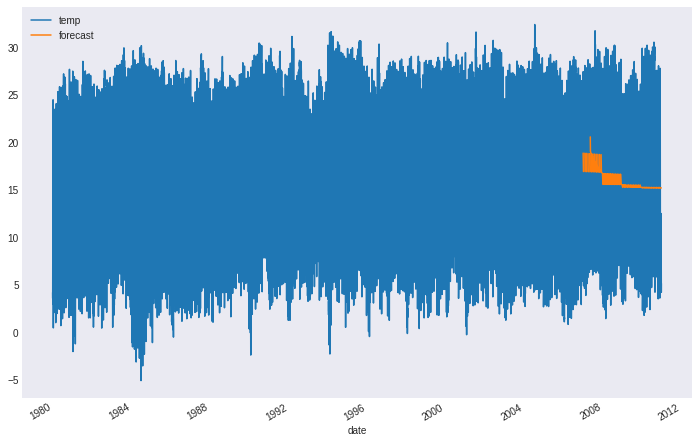

In [93]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(train['temp'],order=(2,0,2))
model_fit=model.fit()

model_fit.summary()

train['forecast']=model_fit.predict(start=10000,end=11321,dynamic=True)
train[['temp','forecast']].plot(figsize=(12,8))

The forecast is poor because data is seasonal, so we need to use `SARIMAX`

In [94]:
import statsmodels.api as sm

In [ ]:
#Start time 
begin = time.time() 

model=sm.tsa.statespace.SARIMAX(train['temp'],order=(2, 1, 2),seasonal_order=(2, 1, 2, 12))
results=model.fit()

#End TIme
end = time.time()
print(f"\n\nTime of execution = {end - begin}")

#Forecast
train['forecast']=results.predict(start=10000,end=11321,dynamic=True)
train[['temp','forecast']].plot(figsize=(12,8))

rmse()

In [ ]:
df = pd.concat([train, test])
df['forecast'] = results.predict(start = 11322, end = 14883, dynamic= True)  
df[['temp', 'forecast']].plot(figsize=(12, 8))

In [ ]:
rmse()

## FBProphet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook's Core Data Science team .

**RESOURCES:**
1. [Documentation](https://pypi.org/project/fbprophet/)
2. [Quick Start](https://facebook.github.io/prophet/docs/quick_start.html)
3. [Hacking Time-Series Forecasting Like a Pro with FBProphet](https://medium.com/tokopedia-data/hacking-time-series-forecasting-like-a-pro-with-fbprophet-76f276f0a058)
4. [Time Series Forecasting With Prophet in Python](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)
5. [A Quick Start of Time Series Forecasting with a Practical Example using FB Prophet](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274)
6. [FBProphet TowardsDataScience](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274)
7. [Generate Quick and Accurate Time Series Forecasts using Facebook’s Prophet (with Python & R codes)](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/)

In [96]:
def prophet_rmse(y_true, y_pred):

  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [97]:
import fbprophet
from fbprophet import Prophet

In [98]:
#Load Data
train, test, submission = load_data()
train['date'] = pd.to_datetime(train['date'])

#Update column names
train.columns = ['ds', 'y']

In [99]:
END_DATE = '2009'
X_train = train[train['ds'] <= END_DATE]
X_test = train[train['ds'] >= END_DATE]

In [100]:
X_train.shape, X_test.shape

((10594, 2), (730, 2))

In [101]:
#Add holidays to model

import holidays


holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [ ]:
# #Box Cox Transformation
# from scipy.stats import boxcox

# # Apply Box-Cox Transform to value column and assign to new column y
# train['y'] = train['y'] + 5.12 #Make Data Positive
# train['y'], lam = boxcox(train['y'])

In [ ]:
# train['y'].min()

-5.11

In [102]:
#Initialize model
model = Prophet(growth = 'linear', 
                  seasonality_mode = 'multiplicative',  
                  changepoint_prior_scale = 30,
                  seasonality_prior_scale = 15,
                  )

#Fit Model
model.fit(X_train)

prediction = model.predict(X_test[['ds']])
rmse = np.sqrt(mean_squared_error(X_test['y'], prediction['yhat']))
rmse

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.65931922523146

In [ ]:
# from fbprophet.diagnostics import cross_validation
# cv_results = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
# cv_results.head()

#Calculate RMSE
# prophet_rmse(cv_results.y, cv_results.yhat)

In [103]:
#Alternate way to calculate rmse (without using cv)
prediction = model.predict(train[['ds']])
# model.plot(prediction);
# model.plot_components(prediction);

rmse = np.sqrt(mean_squared_error(train['y'], prediction['yhat']))
rmse

3.759241306761667

### Inference

In [ ]:
def submit(model, file_name = 'prophet.csv'):

  #Load Test Data
  test = pd.read_csv('/content/drive/MyDrive/Data Science/dare2compete/DTU RoundHacks Data Science Hackathon/new_test.csv')

  #Convert `date` to datetime
  test['date'] = pd.to_datetime(test['date'])

  #Update column names
  test.columns = ['ds']

  #Make Predictions
  test_preds = model.predict(test)

  #Inverse Box Transform
  # from scipy.special import inv_boxcox

  #Apply inverse Box-Cox transform to specific forecast columns
  # test_preds[['yhat','yhat_upper','yhat_lower']] = test_preds[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

  #Inverse Data Addition
  # test_preds['yhat'] = test_preds['yhat'] - 5.12

  #Add prediction to submission file
  submission['prediction'] = test_preds['yhat']

  #Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)
    
  #Downloadingthe csv file
  files.download(file_name)

### Hyperparameter Tuning using Parameter Grid

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


### Prophet Model Tuning

In [ ]:
import random

In [ ]:
strt='1980-01-01'
end='2009-01-01'

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
i = 0

for p in grid:
    test_tune = pd.DataFrame()
    print(f"Iteration: {i+1}/150")
    print(p)
    random.seed(0)

    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_train)

    # train_forecast = train_model.make_future_dataframe(periods=57, freq='D',include_history = False)
    # train_forecast = train[train['ds']>end]
    # train_forecast = train_model.predict(train_forecast[])

    train_forecast = train_model.predict(X_test)
    test_tune=train_forecast[['ds','yhat']]
    # Actual = train[(train['ds']>strt) & (train['ds']<=end)]
    Actual = X_test

    # print(Actual['y'].shape,test_tune['yhat'].shape)

    rmse = np.sqrt(mean_squared_error(Actual['y'],test_tune['yhat']))
    print('RMSE------------------------------------',rmse)
    model_parameters = model_parameters.append({'RMSE':rmse,'Parameters':p},ignore_index=True)
    print()

    i = i+1

    # break

Iteration: 1/150
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
RMSE------------------------------------ 3.763294350883831

Iteration: 2/150
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
RMSE------------------------------------ 3.8416786686986497

Iteration: 3/150
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
RMSE------------------------------------ 3.7561671819466316

Iteration: 4/150
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
RMSE------------------------------------ 3.8370438139542453

Iteration: 5/150
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
RMSE------------------------------------ 3.7689571207603643

Iteratio

In [ ]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,3.756167,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,3.763294,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,3.768957,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,3.780229,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
4,3.780646,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."


In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 150,
 'seasonality_mode': 'multiplicative'}

In [ ]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 150,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_train)

In [ ]:
tuned_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,US-Holidays,US-Holidays_lower,US-Holidays_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2009-01-01,60.061898,-6.848631,18.236525,60.061898,60.061898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.071119,-0.071119,-0.071119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.731401,-0.731401,-0.731401,-0.071119,-0.071119,-0.071119,-0.898713,-0.898713,-0.898713,0.000544,0.000544,0.000544,-0.096737,-0.096737,-0.096737,0.0,0.0,0.0,6.083490
1,2009-01-02,60.062172,-3.127776,23.708247,60.062172,60.062172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.731401,-0.731401,-0.731401,0.000000,0.000000,0.000000,-0.825947,-0.825947,-0.825947,0.001443,0.001443,0.001443,-0.095989,-0.095989,-0.095989,0.0,0.0,0.0,10.454005
2,2009-01-03,60.062447,-1.013002,23.218266,60.062447,60.062447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.731401,-0.731401,-0.731401,0.000000,0.000000,0.000000,-0.828088,-0.828088,-0.828088,-0.001362,-0.001362,-0.001362,-0.095325,-0.095325,-0.095325,0.0,0.0,0.0,10.325480
3,2009-01-04,60.062721,-1.982208,23.077641,60.062721,60.062721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.731401,-0.731401,-0.731401,0.000000,0.000000,0.000000,-0.828894,-0.828894,-0.828894,-0.002705,-0.002705,-0.002705,-0.094788,-0.094788,-0.094788,0.0,0.0,0.0,10.277075
4,2009-01-05,60.062995,-1.407925,22.866679,60.062995,60.062996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.731401,-0.731401,-0.731401,0.000000,0.000000,0.000000,-0.821947,-0.821947,-0.821947,0.003874,0.003874,0.003874,-0.094420,-0.094420,-0.094420,0.0,0.0,0.0,10.694384


In [ ]:
tuned_pred = final_model.predict(X_test)
prophet_rmse(tuned_pred['yhat'], X_test['y'])

3.7561671819466316

## TBATS

There are two interesting time series forecasting methods called BATS and TBATS that are capable of modeling time series with multiple seasonalities.
The names are acronyms for key features of the models: Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components.
TBATS model takes it roots in exponential smoothing methods and can be described by the following equations:
![](https://miro.medium.com/max/700/1*yfruZnSYsNt1X1uyag46eQ.png)

Each seasonality is modeled by a trigonometric representation based on Fourier series. One major advantage of this approach is that it requires only 2 seed states regardless of the length of period. Another advantage is the ability to model seasonal effects of non-integer lengths. For example, given a series of daily observations, one can model leap years with a season of length 365.25.
BATS differs from TBATS only in the way it models seasonal effects. In BATS we have a more traditional approach where each seasonality is modeled by:
![](https://miro.medium.com/max/700/1*D8KY2jQRmVRLHY5f4RNqKA.png)

This implies that BATS can only model integer period lengths. Approach taken in BATS requires m_i seed states for season i, if this season is long the model may become intractable.

**RESOURCES:**
1. [Documentation](https://pypi.org/project/tbats/)
2. [Forecasting Time Series with Multiple Seasonalities using TBATS in Python](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a)
3. [Time-Series Forecasting using TBATS model](https://blog.tenthplanet.in/time-series-forecasting-tbats/)


In [ ]:
!pip install tbats

In [ ]:
train, test, submission = load_data()
train['date'] = pd.to_datetime(train['date'])

END_DATE = '2009'
X_train = train[train['date'] <= END_DATE]
X_test = train[train['date'] >= END_DATE]

In [ ]:
X_train.head()

,date,temp
0,1980-01-01,4.16
1,1980-02-01,4.06
2,1980-03-01,7.12
3,1980-04-01,9.23
4,1980-05-01,3.20


In [ ]:
X_train.shape

(10594, 2)

In [ ]:
X_train.set_index('date', inplace = True)

In [ ]:
X_test.set_index('date', inplace = True)

In [ ]:
from tbats import TBATS, BATS

estimator = TBATS(seasonal_periods = (7, 365.25)  )
model = estimator.fit(X_train)

## End Notes

There are many more methods that you may try out such as using XGBRegressor, LSTM, etc. For me FBProphet worked best so I worked more on it.

ARIMA and TBATS are computationally expensive, so be careful while implementing them. 